# 앙상블회귀

## (공통) 데이터 로딩 및 분할

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings(action='ignore')
df = pd.read_csv('./데이터셋/HousingData.csv')
df = df.ffill()
x = df.drop('MEDV', axis=1)
y = df['MEDV']
x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8, random_state=1)

## Voting
- 동일 데이터셋에 대해 서로 다른 회귀모형 알고리즘을 사용하여 각 모델 예측결과의 평균값을 반환한다.

### 패키지 로딩

In [4]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import VotingRegressor

### 모델생성

In [5]:
lasso = Lasso(alpha=0.05)
ridge = Ridge(alpha = 1)
linear = LinearRegression()
vot_r = VotingRegressor(estimators=[('Lasso',lasso),('Ridge',ridge),('Linear',linear)])

### 학습 및 평가

In [6]:
vot_r.fit(x_train,y_train)
y_hat = vot_r.predict(x_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2-score:{r2_score(y_test, y_hat):.3f}')

RMSE:4.9880009647013885
R2-score:0.748


### 개별 회귀모형 학습결과 비교

In [7]:
estimators = [('Lasso',lasso),('Ridge',ridge),('Linear',linear)]
for name, model in estimators:
    model.fit(x_train,y_train)
    y_hat = model.predict(x_test)
    print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat))}')
    print(f'R2-score:{r2_score(y_test, y_hat):.3f}')
    print('='*80)

RMSE:5.021356937393728
R2-score:0.745
RMSE:4.977514696280816
R2-score:0.749
RMSE:4.975979876218403
R2-score:0.749


## Boosting

### AdaBOOST

#### 패키지로딩

In [8]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

#### 모델생성

In [9]:
ada_r = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),n_estimators=300, random_state=0)

#### 학습 및 평가

In [10]:
ada_r.fit(x_train,y_train)
y_hat = ada_r.predict(x_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2-score:{r2_score(y_test, y_hat):.3f}')

RMSE:3.6056716464950664
R2-score:0.868


### GradientBoost

#### DecisionTreeRegressor 를 활용한 그레디언트 부스팅 원리 이해

In [11]:
from sklearn.tree import DecisionTreeRegressor
np.random.seed(10)
x_ = np.random.rand(100,1) - 0.5 # [-0.5,0.5) 범위 데이터 100x1 모양으로 생성
y_ = 3 * x_[:,0]**2  + 0.05*np.random.randn(100) # y= 3x^2 + noise

In [12]:
y_[:3]

array([0.27623009, 0.70126328, 0.05048995])

In [13]:
tree_reg1 = DecisionTreeRegressor(max_depth=3,random_state=10)
tree_reg1.fit(x_,y_)

DecisionTreeRegressor(max_depth=3, random_state=10)

In [14]:
y2 = y_ - tree_reg1.predict(x_) # 첫번째 모델에 의해 만들어진 오차
tree_reg2 = DecisionTreeRegressor(max_depth=3,random_state=11)
tree_reg2.fit(x_,y2) # 이전 예측기가 만든 오차에 대해 다음 의사결정 나무가 학습

DecisionTreeRegressor(max_depth=3, random_state=11)

In [15]:
y3 = y2 - tree_reg2.predict(x_) # 첫번째 모델에 의해 만들어진 오차
tree_reg3 = DecisionTreeRegressor(max_depth=3,random_state=12)
tree_reg3.fit(x_,y3)

DecisionTreeRegressor(max_depth=3, random_state=12)

- 새로운 샘플에 대한 예측을 만들려면 모든 모델의 예측을 더한다.

In [16]:
x_new = np.array([[-0.4], [0.], [0.5]])
result = np.sum(model.predict(x_new) for model in (tree_reg1, tree_reg2, tree_reg3))
print(result)

[0.48433793 0.02328039 0.67494791]


- 그래디언트 부스트 예측결과 시각화

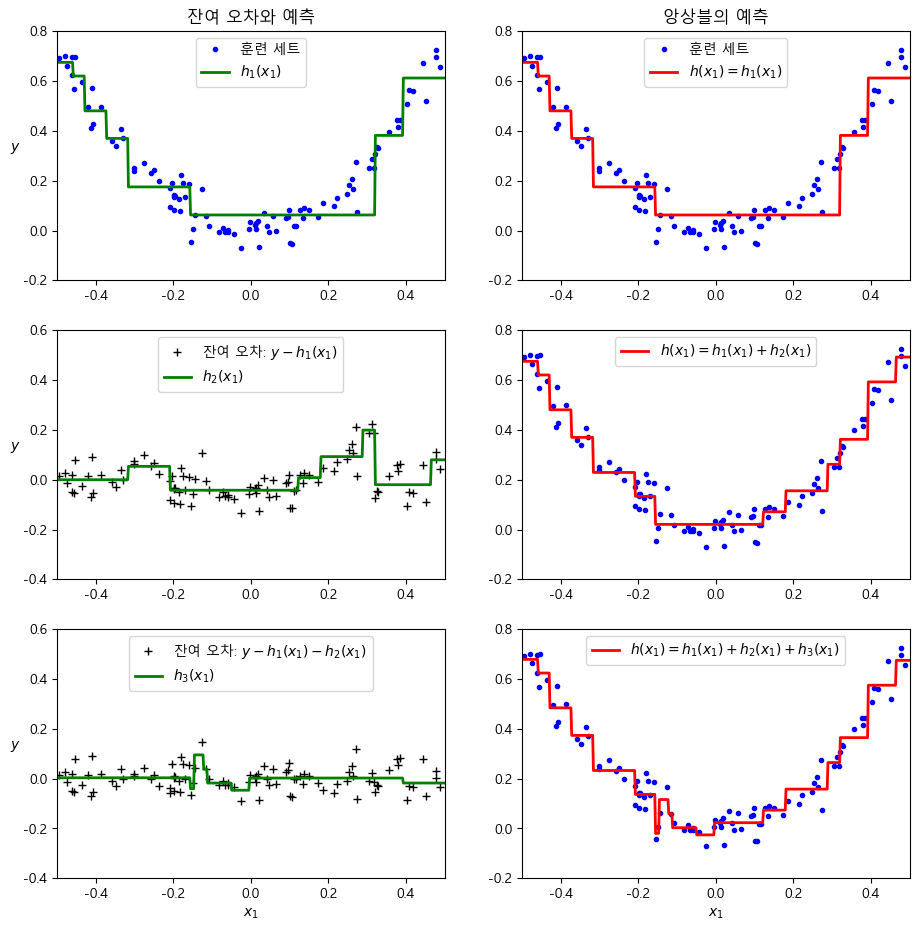

In [17]:
import matplotlib.pyplot as plt
import matplotlib 

matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)    
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$  ", rotation=0)
plt.title("잔여 오차와 예측")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.title("앙상블의 예측")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], x_, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], x_, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], x_, y_,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

### Gradient Boosting Regressor 와의 비교

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
# 학습률 : 각 트리의 기여 정도(default = 1), 낮게 설정하면 훈련데이터를 학습시키기 위해 많은 기여를하게 된다. 미분값이 작거나 학습초기면 학습률 크게 쓰고, 학습막바지거나 미분값이 크면 학습률 작게씀
gbr1 = GradientBoostingRegressor(max_depth=3, n_estimators=3, learning_rate=1)
gbr1.fit(x_,y_)

GradientBoostingRegressor(learning_rate=1, n_estimators=3)

In [20]:
# n_iter_no_change : 조기종료 관련 지정된 횟수의 반복동안 점수향상이 없으면 학습 중단
gbr2 = GradientBoostingRegressor(max_depth=3, n_estimators=500, learning_rate=0.05)
gbr2.fit(x_,y_)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=500)

In [85]:
print(gbr2.n_estimators_)

500


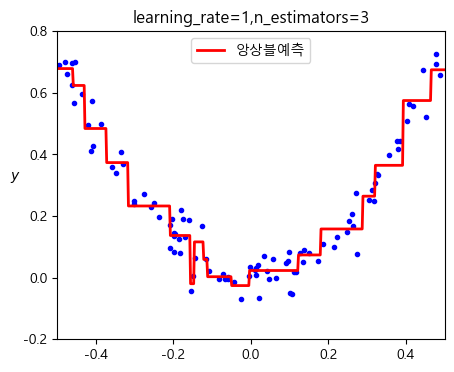

In [21]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plot_predictions([gbr1], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="앙상블예측")
plt.ylabel("$y$  ", rotation=0)
plt.title(f'learning_rate={gbr1.learning_rate},n_estimators={gbr1.n_estimators_}')
plt.show()

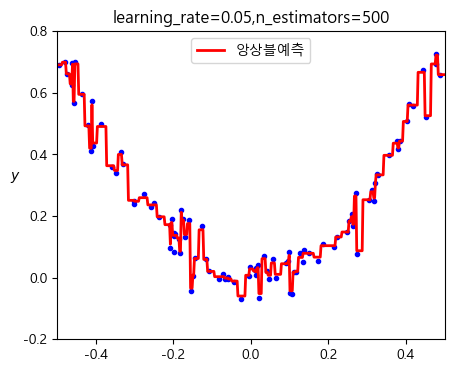

In [22]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plot_predictions([gbr2], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="앙상블예측")
plt.ylabel("$y$  ", rotation=0)
plt.title(f'learning_rate={gbr2.learning_rate},n_estimators={gbr2.n_estimators_}')
plt.show()

#### GradientBoostingRegressor

In [23]:
gbr = GradientBoostingRegressor(
    max_depth=3, n_estimators=300, learning_rate=0.05,random_state=10)#n_iter_no_change = 10

gbr.fit(x_train,y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, random_state=10)

In [24]:
y_hat = gbr.predict(x_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2-score:{r2_score(y_test, y_hat):.3f}')

RMSE:3.1413591808662424
R2-score:0.900


### XGBOOST

In [90]:
!pip install xgboost

#### 파이썬 래퍼 XGBOOST

- 패키지 로딩

In [32]:
import xgboost as xgb

- 학습데이터에서 검증데이터 분리하기

In [33]:
# x_train, y_train 을 분리해서 90은 학습 10은 검증용으로 사용
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, train_size=0.9, random_state=10)

- DMatrix : XGBOOST 전용 데이터 객체

In [34]:
feature_names = df.drop('MEDV',axis = 1).columns
dtrain = xgb.DMatrix(x_train,y_train,feature_names=list(feature_names))
dtest = xgb.DMatrix(x_test,y_test,feature_names=list(feature_names))
dval = xgb.DMatrix(x_val,y_val,feature_names=list(feature_names))

In [ ]:
- 모델 생성 및 학습

In [35]:
params = {
    'eval_matric':'rmse', # 성능평가지표
    'objective' : 'reg:squarederror', # 손실함수 지정
    'max_depth':3, # 의사결정나무의 깊이
    'eta':0.1 # 학습률
}

In [36]:
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=500, early_stopping_rounds=10, evals = [(dtrain, 'train'), (dval, 'eval')])

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)
dval = xgb.DMatrix(x_val, y_val)

[0]	train-rmse:8.01601	eval-rmse:10.35316
[1]	train-rmse:7.41144	eval-rmse:9.62242
[2]	train-rmse:6.88883	eval-rmse:8.96965
[3]	train-rmse:6.39847	eval-rmse:8.36329
[4]	train-rmse:5.96030	eval-rmse:7.80427
[5]	train-rmse:5.56733	eval-rmse:7.37520
[6]	train-rmse:5.21572	eval-rmse:6.94055
[7]	train-rmse:4.90213	eval-rmse:6.64678
[8]	train-rmse:4.59788	eval-rmse:6.35684
[9]	train-rmse:4.33480	eval-rmse:6.06852
[10]	train-rmse:4.10159	eval-rmse:5.85735
[11]	train-rmse:3.87565	eval-rmse:5.64415
[12]	train-rmse:3.68451	eval-rmse:5.41690
[13]	train-rmse:3.51697	eval-rmse:5.25583
[14]	train-rmse:3.36356	eval-rmse:5.10084
[15]	train-rmse:3.23438	eval-rmse:4.98831
[16]	train-rmse:3.10935	eval-rmse:4.90239
[17]	train-rmse:3.01166	eval-rmse:4.79128
[18]	train-rmse:2.90303	eval-rmse:4.65198
[19]	train-rmse:2.81934	eval-rmse:4.59764
[20]	train-rmse:2.73682	eval-rmse:4.48545
[21]	train-rmse:2.66727	eval-rmse:4.41433
[22]	train-rmse:2.59532	eval-rmse:4.35182
[23]	train-rmse:2.52794	eval-rmse:4.30767
[

- 모델평가

In [40]:
y_hat = xgb_model.predict(dtest)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2-score:{r2_score(y_test, y_hat):.3f}')

ValueError: training data did not have the following fields: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT

- Feature Importance

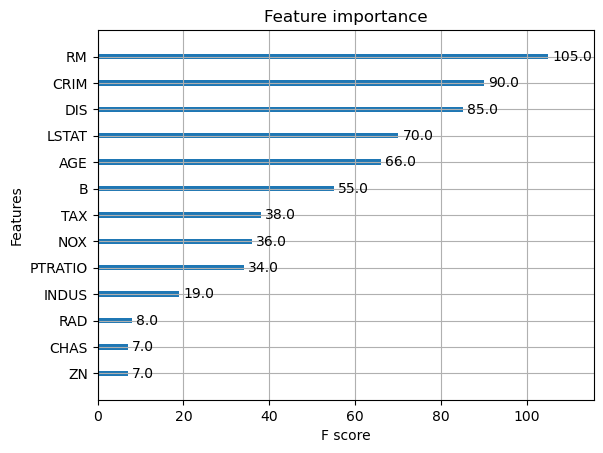

In [38]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model)
plt.show()

#### 사이킷 런 래퍼 XGBOOST

In [63]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(n_estimators = 500, learning_rate = 0.1, max_depths=3)
evals = [(x_train, y_train),(x_val,y_val)]
xgb_reg.fit(x_train, y_train, early_stopping_rounds = 10, eval_metric = 'rmse',eval_set=evals, verbose = True)

[0]	validation_0-rmse:8.18581	validation_1-rmse:10.00711
[1]	validation_0-rmse:7.49476	validation_1-rmse:9.29292
[2]	validation_0-rmse:6.86785	validation_1-rmse:8.64739
[3]	validation_0-rmse:6.30309	validation_1-rmse:8.10198
[4]	validation_0-rmse:5.79392	validation_1-rmse:7.62306
[5]	validation_0-rmse:5.32268	validation_1-rmse:7.14142
[6]	validation_0-rmse:4.90760	validation_1-rmse:6.71163
[7]	validation_0-rmse:4.52095	validation_1-rmse:6.39759
[8]	validation_0-rmse:4.17011	validation_1-rmse:6.07919
[9]	validation_0-rmse:3.84757	validation_1-rmse:5.76036
[10]	validation_0-rmse:3.55826	validation_1-rmse:5.48578
[11]	validation_0-rmse:3.29239	validation_1-rmse:5.23513
[12]	validation_0-rmse:3.05031	validation_1-rmse:5.01003
[13]	validation_0-rmse:2.83194	validation_1-rmse:4.81586
[14]	validation_0-rmse:2.63195	validation_1-rmse:4.65988
[15]	validation_0-rmse:2.44801	validation_1-rmse:4.53502
[16]	validation_0-rmse:2.28532	validation_1-rmse:4.48064
[17]	validation_0-rmse:2.13638	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_depths=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

In [64]:
y_hat = xgb_reg.predict(x_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2-score:{r2_score(y_test, y_hat):.3f}')

RMSE:3.7438768429757294
R2-score:0.858


### LightGBM (사이킷 런 래퍼)

In [65]:
!pip install lightgbm

In [66]:
import lightgbm 

In [67]:
from lightgbm import LGBMRegressor, early_stopping

In [68]:
x_train, x_test, y_train, y_test = train_test_split (x_train,y_train,test_size=0.1,random_state=10)
lgbm_reg = LGBMRegressor(n_estimators=500, learning_rate=0.1,max_depth=3)
evals = [(x_train,y_train),(x_val,y_val)]
lgbm_reg.fit(x_train,y_train, eval_metric='rmse',callbacks=[early_stopping(stopping_rounds=10)],eval_set=evals)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 293, number of used features: 13
[LightGBM] [Info] Start training from score 22.522867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

LGBMRegressor(max_depth=3, n_estimators=500)

In [69]:
y_hat = lgbm_reg.predict(x_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2-score:{r2_score(y_test, y_hat):.3f}')

RMSE:4.807034989243433
R2-score:0.801


# 앙상블 분류

## (공통) 데이터 로딩 및 분할

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer

import numpy as np
import pandas as pd

In [17]:
cancer = load_breast_cancer ()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
print(df.shape)
display(df.head())
x=df
y=cancer.target
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8, stratify=y, random_state=1)

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Voting

### 패키지 로딩

In [9]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### 모델생성

In [13]:
logistic = LogisticRegression(max_iter = 2000)
knn = KNeighborsClassifier(n_neighbors=3)
nb =  GaussianNB()
vo_c = VotingClassifier(estimators = [('Logistic', logistic),('KNN', knn),('Naive_Bayes',nb)], voting= 'soft')

### 학습 및 평가

In [14]:
vo_c.fit(x_train, y_train)
y_hat = vo_c.predict(x_test)
print(f'정확도:{accuracy_score(y_test,y_hat):.3f}')
print(f'AUC: {roc_auc_score(y_test, vo_c.predict_proba(x_test)[:,1]):.3f}')

정확도:0.956
AUC: 0.992


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 개별 분류모형 학습결과 비교

In [15]:
estimators = [('Logistic', logistic),('KNN', knn),('Naive_Bayes',nb)]
for name, model in estimators :
    model.fit(x_train, y_train)
    y_hat = model.predict(x_test)
    print(f'{name} 모델 정확도:{accuracy_score(y_test,y_hat):.3f}')
    print(f'{name} 모델 AUC: {roc_auc_score(y_test, vo_c.predict_proba(x_test)[:,1]):.3f}')
print('='*80)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic 모델 정확도:0.956
Logistic 모델 AUC: 0.992
KNN 모델 정확도:0.947
KNN 모델 AUC: 0.992
Naive_Bayes 모델 정확도:0.939
Naive_Bayes 모델 AUC: 0.992


## Boosting

### AdaBoost

#### 패키지 로딩

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#### 모델 생성

In [17]:
boo_c = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), n_estimators=300, random_state=0)

#### 학습 및 평가

In [18]:
boo_c.fit(x_train, y_train)
y_hat = boo_c.predict(x_test)
print(f'정확도:{accuracy_score(y_test,y_hat):.3f}')
print(f'AUC: {roc_auc_score(y_test, vo_c.predict_proba(x_test)[:,1]):.3f}')

C:\Users\user\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


정확도:0.974
AUC: 0.992


### GradientBoost

#### 패키지로딩

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

####  모델 생성 및 학습

In [20]:
gb_c = GradientBoostingClassifier(random_state=0)
gb_c.fit(x_train,y_train)
y_hat = gb_c.predict(x_test)
print(f'정확도:{accuracy_score(y_test,y_hat):.3f}')
print(f'AUC: {roc_auc_score(y_test, vo_c.predict_proba(x_test)[:,1]):.3f}')

정확도:0.965
AUC: 0.992


# 하이퍼 파라미터 튜닝

In [21]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [200,300],
    'max_depth' : [3,6,8],
    'min_samples_split': [2,3,5,10],
    'learning_rate':[0.05,0.1,0.2]
}

gb_grid = GridSearchCV(gb_c, params, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid.fit(x,y)
print(f'최적 파라메터:',gb_grid.best_params_)
print(f'평균정확도: {gb_grid.best_score_}')

최적 파라메터: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}
평균정확도: 0.9666200900481291


In [23]:
estimator = gb_grid.best_estimator_
y_hat = estimator.predict(x_test)
print(f'정확도:{accuracy_score(y_test,y_hat):.3f}')
print(f'AUC: {roc_auc_score(y_test, estimator.predict_proba(x_test)[:,1]):.3f}')

정확도:1.000
AUC: 1.000


### XGBoost (사이킷런 래퍼)

In [18]:
# 학습데이터로부터 10퍼센트의 검증용 데이터를 분리
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,train_size=0.9,random_state=10, stratify=y_train)

In [19]:
from xgboost import XGBClassifier

xgb_c = XGBClassifier(n_estimators = 300, learning_rate = 0.05, max_depth=3)
evals = [(x_train, y_train), (x_val,y_val)]
# logloss 분류문제에 사용되는 손실함수, cross-entropy 에러라고도 한다
xgb_c.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)

[0]	validation_0-logloss:0.61900	validation_1-logloss:0.62001
[1]	validation_0-logloss:0.58116	validation_1-logloss:0.58546
[2]	validation_0-logloss:0.54623	validation_1-logloss:0.55312
[3]	validation_0-logloss:0.51507	validation_1-logloss:0.52506
[4]	validation_0-logloss:0.48661	validation_1-logloss:0.49810
[5]	validation_0-logloss:0.46025	validation_1-logloss:0.47340
[6]	validation_0-logloss:0.43610	validation_1-logloss:0.45175


C:\Users\user\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-logloss:0.41358	validation_1-logloss:0.43120
[8]	validation_0-logloss:0.39286	validation_1-logloss:0.41211
[9]	validation_0-logloss:0.37402	validation_1-logloss:0.39391
[10]	validation_0-logloss:0.35586	validation_1-logloss:0.37862
[11]	validation_0-logloss:0.33951	validation_1-logloss:0.36225
[12]	validation_0-logloss:0.32365	validation_1-logloss:0.34959
[13]	validation_0-logloss:0.30898	validation_1-logloss:0.33336
[14]	validation_0-logloss:0.29553	validation_1-logloss:0.31960
[15]	validation_0-logloss:0.28260	validation_1-logloss:0.30523
[16]	validation_0-logloss:0.27076	validation_1-logloss:0.29306
[17]	validation_0-logloss:0.25931	validation_1-logloss:0.28031
[18]	validation_0-logloss:0.24883	validation_1-logloss:0.27070
[19]	validation_0-logloss:0.23863	validation_1-logloss:0.25921
[20]	validation_0-logloss:0.22930	validation_1-logloss:0.24964
[21]	validation_0-logloss:0.22018	validation_1-logloss:0.23936
[22]	validation_0-logloss:0.21133	validation_1-logloss:0.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
y_hat = xgb_c.predict(x_test)
print(f'정확도:{accuracy_score(y_test,y_hat):.3f}')
print(f'AUC: {roc_auc_score(y_test, xgb_c.predict_proba(x_test)[:,1]):.3f}')

정확도:0.974
AUC: 0.996


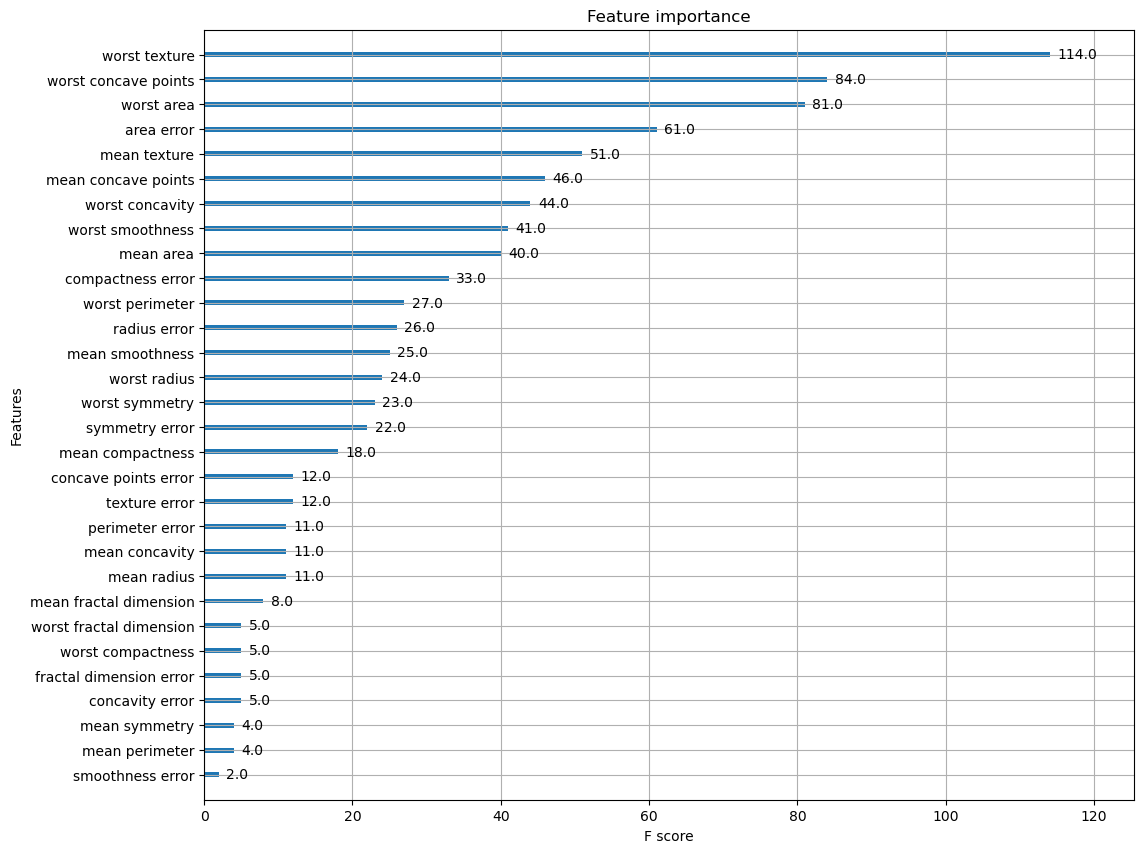

In [22]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

fig, ax = plt.subplots(figsize = (12,10))
plot_importance(xgb_c,ax=ax)
plt.show()

### LightGBM (사이킷런 래퍼)

In [23]:
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
lgbm_c = LGBMClassifier(n_estimators = 300, learning_rate = 0.05)
evals = [(x_train, y_train), (x_val,y_val)]
callbacks = [early_stopping(stopping_rounds=10)]
lgbm_c.fit(x_train, y_train, eval_metric='logloss',callbacks=callbacks, eval_set=evals)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28, number of negative: 17
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622222 -> initscore=0.498991
[LightGBM] [Info] Start training from score 0.498991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LGBMClassifier(learning_rate=0.05, n_estimators=300)

In [24]:
y_hat = lgbm_c.predict(x_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2-score:{r2_score(y_test, y_hat):.3f}')

RMSE:0.3244428422615251
R2-score:0.548


## Stacking

### 패키지로딩

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression  # 2번쨰 메타모델

### 모델생성

In [8]:
knn_1st = KNeighborsClassifier(n_neighbors=3)
rf_1st = RandomForestClassifier(random_state=0)
dt_1st = DecisionTreeClassifier()
ada_1st = AdaBoostClassifier(n_estimators=200)

lr_final = LogisticRegression()

### 학습 및 평가

In [10]:
knn_1st.fit(x_train,y_train)
rf_1st.fit(x_train,y_train)
ada_1st.fit(x_train,y_train)
dt_1st.fit(x_train,y_train)

DecisionTreeClassifier()

In [11]:
knn_pred = knn_1st.predict(x_test)
rf_pred = rf_1st.predict(x_test)
ada_pred = ada_1st.predict(x_test)
dt_pred = dt_1st.predict(x_test)

### 스태킹 (Stacking)

In [13]:
print(knn_pred.shape)
y_hat = np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(y_hat.shape)
y_hat = np.transpose(y_hat)
print(y_hat.shape)

(114,)
(4, 114)
(114, 4)


### 메타모델 학습 및 평가

In [17]:
lr_final.fit(y_hat, y_test)
final_y_hat = lr_final.predict(y_hat)
print('최종메타모델의 예측 정확도: ',accuracy_score(y_test,final_y_hat))

최종메타모델의 예측 정확도:  0.9736842105263158
